# 🎯 Notebook 4/6 — Otimização de Hiperparâmetros
## Ligia NLP Challenge — Detecção de Fake News

| Informação | Detalhe |
|---|---|
| **Entrada** | `data/processed/X_*_tfidf.npz`, `tfidf_vectorizer.joblib` |
| **Saída** | `models/mlclassico/optimized/*.joblib`, `reports/optimized_results.csv` |
| **Notebook anterior** | `3.0-baseline-models.ipynb` |
| **Próximo Notebook** | `4.0-predictions.ipynb` |
| **Tempo estimado** | ~45–60 min (sem GPU) |

## Objetivo
Otimizar os **3 melhores modelos** selecionados no notebook 3.0 usando **Character N-grams (4-6)**:
1. **LinearSVC**
2. **SGDClassifier**
3. **Extra Trees**

## Estratégias de Otimização
1. **Randomized Search CV** — Exploração eficiente do espaço de hiperparâmetros
2. **Cross-Validation Estratificado** — 5-fold para melhor generalização
3. **Scoring: F1-weighted** — Métrica principal
4. **Curvas de Aprendizado** — Diagnóstico de overfitting/underfitting

## Hiperparâmetros a Otimizar

### Extra Trees
- `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `class_weight`

### LinearSVC
- `C`, `loss`, `max_iter`, `tol`

### SGDClassifier
- `alpha`, `penalty`, `loss`, `max_iter`, `learning_rate`

## Estrutura do Notebook
1. Setup
2. Carregar Dados Vetorizados
3. Otimização LinearSVC
4. Otimização SGDClassifier
5. Otimização Extra Trees
6. Comparação Final: Baseline vs Otimizado
7. Salvar Modelos Otimizados
8. Salvar Resultados em CSV


## 1. Setup

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
import joblib
from pathlib import Path
warnings.filterwarnings('ignore')
import scipy.sparse
import os
import json

# Scikit-learn
from sklearn.model_selection import (
    RandomizedSearchCV, learning_curve, StratifiedKFold
)
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    accuracy_score, precision_score, recall_score,
    make_scorer
)

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

# Configuração de plotagem
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)
MODEL_DIR = '../models/mlclassico/optimized'
os.makedirs(MODEL_DIR, exist_ok=True)

print("✅ Bibliotecas carregadas com sucesso!")


✅ Bibliotecas carregadas com sucesso!


## 2. Carregar Dados Vetorizados


In [ ]:
PROCESSED_PATH = '../data/processed'

# Carregar matrizes TF-IDF Character N-grams (4-6)
X_train_tfidf = scipy.sparse.load_npz(os.path.join(PROCESSED_PATH, 'X_train_tfidf.npz'))
X_val_tfidf = scipy.sparse.load_npz(os.path.join(PROCESSED_PATH, 'X_val_tfidf.npz'))

# Carregar labels
y_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'y_train.csv'))['label']
y_val = pd.read_csv(os.path.join(PROCESSED_PATH, 'y_val.csv'))['label']

# Carregar vetorizador TF-IDF Character N-grams
tfidf = joblib.load(os.path.join(PROCESSED_PATH, 'tfidf_vectorizer.joblib'))



# ============================================================
# Configuracoes comuns para otimizacao
# ============================================================

# Cross-validation estratificado 5-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Scorer F1-weighted para otimização
f1_scorer = make_scorer(f1_score, average='weighted')


print("=" * 70)
print("✅ DADOS CARREGADOS - CHARACTER N-GRAMS (4-6)")
print("=" * 70)
print(f"\n📊 Matrizes:")
print(f"   X_train_tfidf: {X_train_tfidf.shape[0]:,} × {X_train_tfidf.shape[1]:,} features")
print(f"   X_val_tfidf:   {X_val_tfidf.shape[0]:,} × {X_val_tfidf.shape[1]:,} features")

✅ DADOS CARREGADOS - CHARACTER N-GRAMS (4-6)

📊 Matrizes:
   X_train_tfidf: 17,871 × 50,000 features
   X_val_tfidf:   4,468 × 50,000 features

🔢 Labels:
   y_train: 17,871 amostras - {0: np.int64(13595), 1: np.int64(4276)}
   y_val:   4,468 amostras - {0: np.int64(3399), 1: np.int64(1069)}


## 3. Otimização LinearSVC

⚡ OTIMIZAÇÃO LINEAR SVC — RandomizedSearchCV
Fitting 5 folds for each of 15 candidates, totalling 75 fits

⏱️  Tempo total: 105.4s
🏆 Melhor F1 CV: 0.9993

📋 Melhores hiperparâmetros:
   tol: 1e-05
   penalty: l2
   max_iter: 2000
   loss: squared_hinge
   dual: True
   C: 10.0
📊 AVALIAÇÃO LinearSVC OTIMIZADO
   Accuracy:  0.9991
   F1:        0.9991
   Precision: 0.9991
   Recall:    0.9991

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



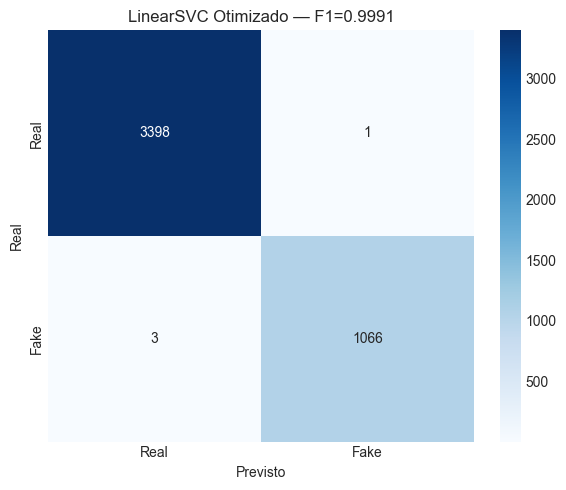

In [3]:

svc_param_dist = {
    'C': [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
}

print("=" * 70)
print("⚡ OTIMIZAÇÃO LINEAR SVC — RandomizedSearchCV")
print("=" * 70)

svc_base = LinearSVC(random_state=SEED)

svc_search = RandomizedSearchCV(
    estimator=svc_base,
    param_distributions=svc_param_dist,
    n_iter=15,
    scoring=f1_scorer,
    cv=cv_strategy,
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

t0 = time.time()
svc_search.fit(X_train_tfidf, y_train)
svc_opt_time = time.time() - t0

print(f"\n⏱️  Tempo total: {svc_opt_time:.1f}s")
print(f"🏆 Melhor F1 CV: {svc_search.best_score_:.4f}")
print(f"\n📋 Melhores hiperparâmetros:")
for param, val in svc_search.best_params_.items():
    print(f"   {param}: {val}")

# Wrap com CalibratedClassifierCV para ter predict_proba
svc_best_raw = svc_search.best_estimator_
svc_best = CalibratedClassifierCV(svc_best_raw, cv=3)
svc_best.fit(X_train_tfidf, y_train)



y_pred_svc = svc_best.predict(X_val_tfidf)

svc_f1 = f1_score(y_val, y_pred_svc, average='weighted')
svc_acc = accuracy_score(y_val, y_pred_svc)
svc_prec = precision_score(y_val, y_pred_svc, average='weighted')
svc_rec = recall_score(y_val, y_pred_svc, average='weighted')

print("=" * 70)
print("📊 AVALIAÇÃO LinearSVC OTIMIZADO")
print("=" * 70)
print(f"   Accuracy:  {svc_acc:.4f}")
print(f"   F1:        {svc_f1:.4f}")
print(f"   Precision: {svc_prec:.4f}")
print(f"   Recall:    {svc_rec:.4f}")
print(f"\n{classification_report(y_val, y_pred_svc, target_names=['Real (0)', 'Fake (1)'])}")

# Matriz de confusão
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
ax.set_title(f'LinearSVC Otimizado — F1={svc_f1:.4f}')
ax.set_ylabel('Real')
ax.set_xlabel('Previsto')
plt.tight_layout()
plt.show()


## 4. Otimização do SGDClassifier

In [4]:
sgd_param_dist = {
    'alpha': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': ['hinge', 'modified_huber', 'log_loss'],
    'max_iter': [1000, 2000, 3000],
    'learning_rate': ['optimal', 'adaptive', 'constant'],
    'eta0': [0.001, 0.01, 0.1],
    'tol': [1e-3, 1e-4],
    'l1_ratio': uniform(0.1, 0.8),
}

print("=" * 70)
print("⚡ OTIMIZAÇÃO SGDClassifier — RandomizedSearchCV")
print("=" * 70)

sgd_base = SGDClassifier(random_state=SEED, n_jobs=-1)
sgd_search = RandomizedSearchCV(
    estimator=sgd_base,
    param_distributions=sgd_param_dist,
    n_iter=20,
    scoring=f1_scorer,
    cv=cv_strategy,
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    refit=True,
)

t0 = time.time()
sgd_search.fit(X_train_tfidf, y_train)
sgd_opt_time = time.time() - t0

print(f"\n⏱️  Tempo total: {sgd_opt_time:.1f}s")
print(f"🏆 Melhor F1 CV: {sgd_search.best_score_:.4f}")
print(f"\n📋 Melhores hiperparâmetros:")
for param, val in sgd_search.best_params_.items():
    print(f"   {param}: {val}")

# Avaliar no conjunto de validação
sgd_best = sgd_search.best_estimator_
y_pred_sgd = sgd_best.predict(X_val_tfidf)

sgd_f1 = f1_score(y_val, y_pred_sgd, average='weighted')
sgd_acc = accuracy_score(y_val, y_pred_sgd)
sgd_prec = precision_score(y_val, y_pred_sgd, average='weighted')
sgd_rec = recall_score(y_val, y_pred_sgd, average='weighted')

print(f"\n📊 Validação:")
print(f"   Accuracy:  {sgd_acc:.4f}")
print(f"   F1:        {sgd_f1:.4f}")
print(f"   Precision: {sgd_prec:.4f}")
print(f"   Recall:    {sgd_rec:.4f}")
print(f"\n{classification_report(y_val, y_pred_sgd, target_names=['Real (0)', 'Fake (1)'])}")

⚡ OTIMIZAÇÃO SGDClassifier — RandomizedSearchCV
Fitting 5 folds for each of 20 candidates, totalling 100 fits

⏱️  Tempo total: 310.8s
🏆 Melhor F1 CV: 0.9992

📋 Melhores hiperparâmetros:
   alpha: 5e-05
   eta0: 0.1
   l1_ratio: 0.6208616204015556
   learning_rate: constant
   loss: hinge
   max_iter: 2000
   penalty: l2
   tol: 0.0001

📊 Validação:
   Accuracy:  0.9989
   F1:        0.9989
   Precision: 0.9989
   Recall:    0.9989

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 5. Otimização do ExtraTrees

In [ ]:
et_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [30, 50, 70, 100, None],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': [None, 'balanced'],
}

print("=" * 70)
print("🌳 OTIMIZAÇÃO EXTRA TREES — RandomizedSearchCV")
print("=" * 70)

et_base = ExtraTreesClassifier(random_state=SEED, n_jobs=-1)

et_search = RandomizedSearchCV(
    estimator=et_base,
    param_distributions=et_param_dist,
    n_iter=10,
    scoring=f1_scorer,
    cv=cv_strategy,
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

t0 = time.time()
et_search.fit(X_train_tfidf, y_train)
et_opt_time = time.time() - t0

print(f"\n⏱️  Tempo total: {et_opt_time:.1f}s")
print(f"🏆 Melhor F1 CV: {et_search.best_score_:.4f}")
print(f"\n📋 Melhores hiperparâmetros:")
for param, val in et_search.best_params_.items():
    print(f"   {param}: {val}")

# Avaliar no conjunto de validação
et_best = et_search.best_estimator_
y_pred_et = et_best.predict(X_val_tfidf)

et_f1 = f1_score(y_val, y_pred_et, average='weighted')
et_acc = accuracy_score(y_val, y_pred_et)
et_prec = precision_score(y_val, y_pred_et, average='weighted')
et_rec = recall_score(y_val, y_pred_et, average='weighted')

print(f"\n📊 Validação:")
print(f"   Accuracy:  {et_acc:.4f}")
print(f"   F1:        {et_f1:.4f}")
print(f"   Precision: {et_prec:.4f}")
print(f"   Recall:    {et_rec:.4f}")
print(f"\n{classification_report(y_val, y_pred_et, target_names=['Real (0)', 'Fake (1)'])}")


🌳 OTIMIZAÇÃO EXTRA TREES — RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits

⏱️  Tempo total: 3092.5s
🏆 Melhor F1 CV: 0.9996

📋 Melhores hiperparâmetros:
   n_estimators: 300
   min_samples_split: 2
   min_samples_leaf: 2
   max_features: 0.3
   max_depth: 100
   class_weight: balanced

📊 Validação:
   Accuracy:  0.9998
   F1:        0.9998
   Precision: 0.9998
   Recall:    0.9998

              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      3399
    Fake (1)       1.00      1.00      1.00      1069

    accuracy                           1.00      4468
   macro avg       1.00      1.00      1.00      4468
weighted avg       1.00      1.00      1.00      4468



## 6. Comparação Final: Baseline vs Otimizado

📊 COMPARAÇÃO: BASELINE vs OTIMIZADO

  Extra Trees:
    Baseline:  F1=0.9998
    Otimizado: F1=0.9998  (CV=0.9996)
    Delta:     +0.0000 →

  LinearSVC:
    Baseline:  F1=0.9991
    Otimizado: F1=0.9991  (CV=0.9993)
    Delta:     +0.0000 ↑

  SGDClassifier:
    Baseline:  F1=0.9989
    Otimizado: F1=0.9989  (CV=0.9992)
    Delta:     +0.0000 ↑


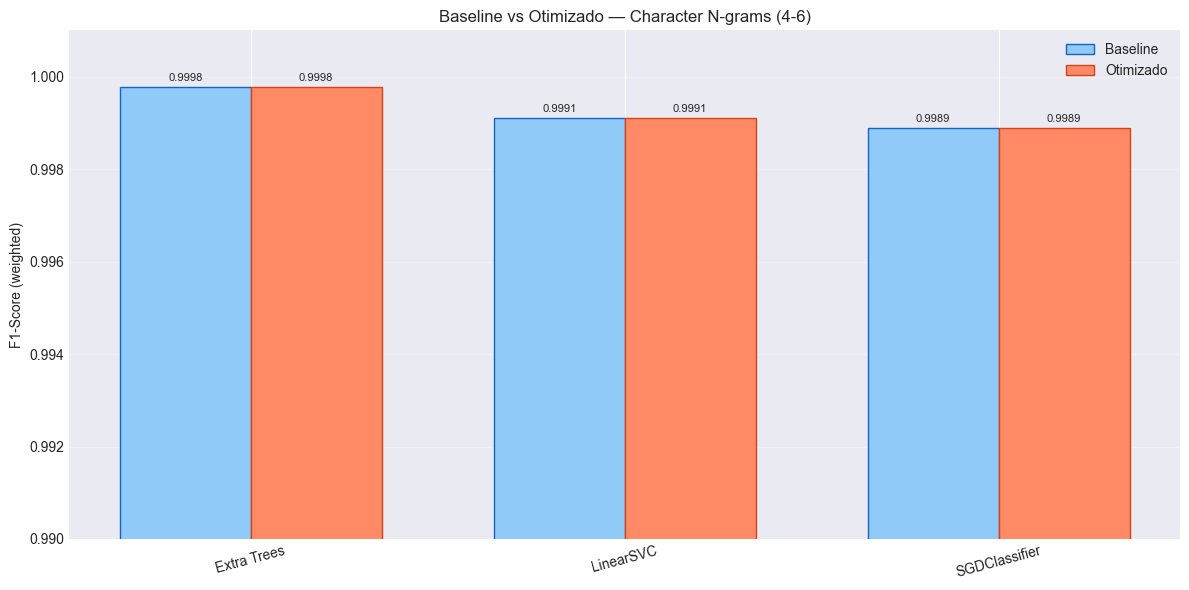


🏆 Melhor modelo otimizado: Extra Trees com F1=0.9998


In [6]:
# Carregar resultados baseline do char_ngrams
baseline_df = pd.read_csv('../reports/baseline_results_char_ngrams.csv')

# Resultados otimizados (sem Random Forest)
optimized_results = pd.DataFrame([
    {
        'Modelo': 'LinearSVC',
        'Accuracy': svc_acc, 'F1 (weighted)': svc_f1,
        'Precision': svc_prec, 'Recall': svc_rec,
        'F1 CV (mean)': svc_search.best_score_,
        'Melhores Parâmetros': str(svc_search.best_params_),
    },
    {
        'Modelo': 'SGDClassifier',
        'Accuracy': sgd_acc, 'F1 (weighted)': sgd_f1,
        'Precision': sgd_prec, 'Recall': sgd_rec,
        'F1 CV (mean)': sgd_search.best_score_,
        'Melhores Parâmetros': str(sgd_search.best_params_),
    },
    {
        'Modelo': 'Extra Trees',
        'Accuracy': et_acc, 'F1 (weighted)': et_f1,
        'Precision': et_prec, 'Recall': et_rec,
        'F1 CV (mean)': et_search.best_score_,
        'Melhores Parâmetros': str(et_search.best_params_),
    },
])

optimized_results = optimized_results.sort_values('F1 (weighted)', ascending=False).reset_index(drop=True)

print("=" * 80)
print("📊 COMPARAÇÃO: BASELINE vs OTIMIZADO")
print("=" * 80)

# Tabela side-by-side
for _, opt_row in optimized_results.iterrows():
    modelo = opt_row['Modelo']
    base_row = baseline_df[baseline_df['Modelo'] == modelo]
    
    if not base_row.empty:
        base_f1 = base_row['F1 (weighted)'].values[0]
        opt_f1 = opt_row['F1 (weighted)']
        delta = opt_f1 - base_f1
        arrow = '↑' if delta > 0 else ('↓' if delta < 0 else '→')
        
        print(f"\n  {modelo}:")
        print(f"    Baseline:  F1={base_f1:.4f}")
        print(f"    Otimizado: F1={opt_f1:.4f}  (CV={opt_row['F1 CV (mean)']:.4f})")
        print(f"    Delta:     {delta:+.4f} {arrow}")

# Gráfico comparativo
fig, ax = plt.subplots(figsize=(12, 6))

modelos = optimized_results['Modelo'].tolist()
x = np.arange(len(modelos))
width = 0.35

baseline_f1s = []
for m in modelos:
    row = baseline_df[baseline_df['Modelo'] == m]
    baseline_f1s.append(row['F1 (weighted)'].values[0] if not row.empty else 0)

opt_f1s = optimized_results['F1 (weighted)'].tolist()

bars1 = ax.bar(x - width/2, baseline_f1s, width, label='Baseline', color='#90CAF9', edgecolor='#1565C0')
bars2 = ax.bar(x + width/2, opt_f1s, width, label='Otimizado', color='#FF8A65', edgecolor='#D84315')

ax.set_ylabel('F1-Score (weighted)')
ax.set_title('Baseline vs Otimizado — Character N-grams (4-6)')
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=15)
ax.legend()
ax.set_ylim(0.99, 1.001)
ax.grid(axis='y', alpha=0.3)

# Anotar valores
for bar in bars1:
    ax.annotate(f'{bar.get_height():.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../reports/figures/baseline_vs_optimized_char_ngrams.png', dpi=300, bbox_inches='tight')
plt.show()

# Melhor modelo geral
best_opt = optimized_results.iloc[0]
print(f"\n🏆 Melhor modelo otimizado: {best_opt['Modelo']} com F1={best_opt['F1 (weighted)']:.4f}")

## 7. Salvar Modelos Otimizados

In [ ]:


# Mapear modelos otimizados (sem Random Forest)
optimized_models = {
    'linearsvc': {'model': svc_best, 'search': svc_search, 'f1': svc_f1, 'acc': svc_acc},
    'sgdclassifier': {'model': sgd_best, 'search': sgd_search, 'f1': sgd_f1, 'acc': sgd_acc},
    'extratrees': {'model': et_best, 'search': et_search, 'f1': et_f1, 'acc': et_acc},
}

print("=" * 70)
print("💾 SALVANDO MODELOS OTIMIZADOS")
print("=" * 70)

metadata_opt = {}

for name, info in optimized_models.items():
    filename = f'{name}_optimized.joblib'
    filepath = os.path.join(MODEL_DIR, filename)
    joblib.dump(info['model'], filepath)
    
    metadata_opt[name] = {
        'model': name,
        'best_params': info['search'].best_params_,
        'f1_cv': float(info['search'].best_score_),
        'f1_val': float(info['f1']),
        'accuracy_val': float(info['acc']),
        'file': filename,
    }
    
    print(f"   ✅ {filename}")
    print(f"      F1 CV={info['search'].best_score_:.4f} | F1 Val={info['f1']:.4f}")

# Adicionar metadados do dataset
metadata_opt['dataset'] = {
    'train_size': X_train_tfidf.shape[0],
    'val_size': X_val_tfidf.shape[0],
    'n_features': X_train_tfidf.shape[1],
    'method': 'Character N-grams (4-6)',
    'ngram_range': [4, 6],
}

# Salvar metadados
with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f:
    json.dump(metadata_opt, f, indent=2, default=str)

print(f"\n📄 Metadados salvos em {MODEL_DIR}/metadata.json")
print(f"✅ {len(optimized_models)} modelos salvos em {MODEL_DIR}/")

💾 SALVANDO MODELOS OTIMIZADOS
   ✅ linearsvc_optimized.joblib
      F1 CV=0.9993 | F1 Val=0.9991
   ✅ sgdclassifier_optimized.joblib
      F1 CV=0.9992 | F1 Val=0.9989
   ✅ extratrees_optimized.joblib
      F1 CV=0.9996 | F1 Val=0.9998

📄 Metadados salvos em ../models/optimized/metadata.json
✅ 3 modelos salvos em ../models/optimized/


## 8. Salvar Resultados em CSV

In [ ]:
os.makedirs('../reports', exist_ok=True)

optimized_results.to_csv('../reports/optimized_results.csv', index=False)


📄 RESULTADOS SALVOS

   → reports/optimized_results_char_ngrams.csv

📊 Tabela final:
       Modelo  Accuracy  F1 (weighted)  F1 CV (mean)
  Extra Trees    0.9998         0.9998        0.9996
    LinearSVC    0.9991         0.9991        0.9993
SGDClassifier    0.9989         0.9989        0.9992
